**ML COURSE 2024-2025**
# LAB6 UNSUPERVISED ML - Clustering and Anomaly Detection
In this lab you will see K-Means and Agglomerative Hierarchical Clustering, and Hotelling T2 and Isolation Forest for anomaly detection (Lectures 19-20).

In [3]:
!git clone https://github.com/AMCO-UniPD/ML_lab_DEI_public.git

Cloning into 'ML_lab_DEI_public'...
remote: Enumerating objects: 194, done.
remote: Counting objects: 100% (194/194), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 194 (delta 80), reused 139 (delta 40), pack-reused 0 (from 0)
Receiving objects: 100% (194/194), 25.97 MiB | 17.87 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [ ]:
%cd ..

In [10]:
import numpy as np
from dataclasses import dataclass
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from utils import generate_blobs_dataset, centroids_animation

np.random.seed(42)

## Clustering

### K-Means

We took inspiration from [here](https://medium.com/@avijit.bhattacharjee1996/implementing-k-means-clustering-from-scratch-in-python-a277c23563ac).

In [ ]:
def pairwise_distances(X, centroids):
    """Returns the pairwise distance of each point in X with respect to each centroid.

    Args:
        X (np.ndarray): Data points of shape (n_samples, n_features).
        centroids (np.ndarray): Centroids of shape (n_centroids, n_features).
    """
    # distances = np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=2) # more efficient but less intuitive
    pairwise_distances = np.zeros((X.shape[0], centroids.shape[0]))
    for i in range(X.shape[0]):
        for j in range(centroids.shape[0]): # trovo le distanze di un punto con tutti i centroidi
            pairwise_distances[i, j] = np.linalg.norm(X[i] - centroids[j])
    return pairwise_distances

In [ ]:
class KMeansClustering:
    def __init__(self, n_clusters:int, max_iters:int=100, tol:float=1e-6):
        """
        Args:
            n_clusters: int - the number of clusters.
            max_iters: int - maximum number of iterations.
            tol: float - tolerance for convergence.
            random_state: int - seed for reproducibility.
        """
        self.k = n_clusters
        self.max_iters = max_iters
        self.tol = tol
        self.centroids = None
        self.labels_ = None         # here we store the labels for the training point
        self.history = []           # here we store the history of centroids

    def _assign_clusters(self, X):
        distances = pairwise_distances(X, self.centroids)
        clusters = np.argmin(distances, axis=1)
        return clusters

    def _update_centroids(self, X, labels):
        new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(self.k)])
        return new_centroids

    def fit(self, X):
        self.history = []
        self.labels_history = []

        # centroids randomly initialized at the beginning
        self.centroids = X[np.random.choice(X.shape[0], self.k, replace=False)]
        labels = self._assign_clusters(X)

        self.history.append(self.centroids.copy())
        self.labels_history.append(labels.copy())

        # iterate until convergence or max_iters
        for _ in range(self.max_iters):
            new_centroids = self._update_centroids(X, labels)
            if np.all(np.abs(new_centroids - self.centroids) < self.tol):
                break
            self.centroids = new_centroids
            labels = self._assign_clusters(X)

            self.history.append(self.centroids.copy())
            self.labels_history.append(labels.copy())

        # assign the final training labels
        self.labels_ = labels
        return self

#### Kmeans convergence is sensible to centroids initialization

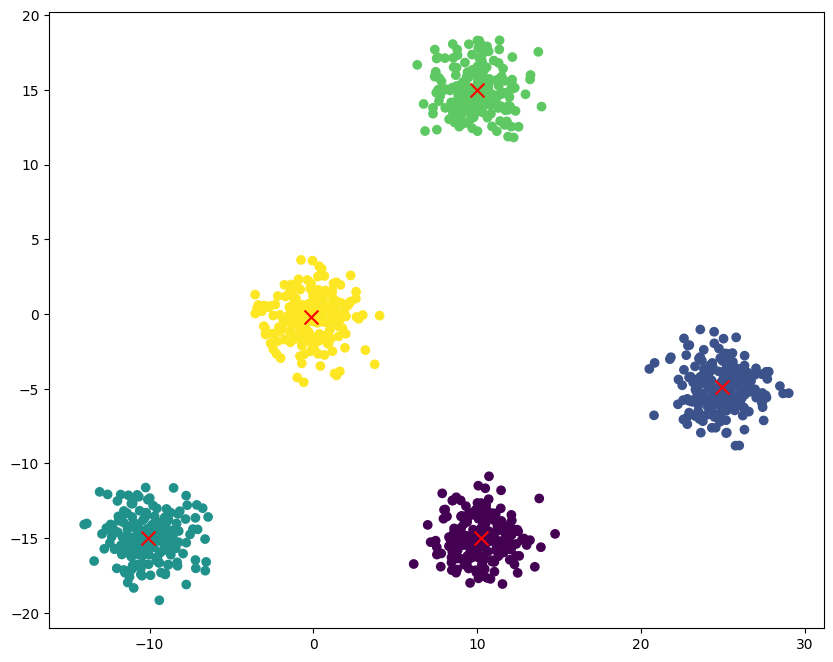

In [ ]:
from sklearn.datasets import make_blobs
custom_centers = [[-10, -15], [0, 0], [10, -15], [25, -5], [10, 15]]
Xblobs, _ = make_blobs(n_samples=1000, centers=custom_centers, cluster_std=1.5, random_state=0)

kmeans = KMeansClustering(n_clusters=5)
kmeans.fit(Xblobs)

# plot results
plt.figure(figsize=(10, 8))
plt.scatter(Xblobs[:, 0], Xblobs[:, 1], c=kmeans.labels_)
plt.scatter(kmeans.centroids[:, 0], kmeans.centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.show()

centroids = np.stack(kmeans.history, axis=0).transpose(1, 0, 2)
labels = np.stack(kmeans.labels_history, axis=0)
centroids_animation(Xblobs, centroids, labels, t_interval=600)

### Determine the optimal number of clusters

#### Elbow Method

The elbow method is a heuristic that helps us determine a good number of clusters.  
This helps us when we don't know how many clusters we should tell our clustering algorithm to find.  
This is a graphical method that works by computing a score over a range of possibile $k$ (number of clusters) values.

The score we compute is the mean _Within-Cluster Dispersion_ ($W(k)$), defined as:

$$
W(k) = \sum_{i=1}^{k} \sum_{x \in C_i} ||x - \mu_i||^2\\
W_{\text{mean}}(k) = \frac{1}{k} W(k)
$$

Where $C_i$ is the $i$-th cluster, $\mu_i$ is the centroid of the $i$-th cluster, and $x$ is a point in the dataset.

In [ ]:
def compute_Wk(X, labels, centroids):
    """Compute the within-cluster dispersion Wk, with k clusters, for each centroid."""
    n_clusters = centroids.shape[0]
    Wk = np.zeros(n_clusters)
    for i in range(n_clusters):
        Wk[i] = np.sum((X[labels == i] - centroids[i]) ** 2)
    return np.sum(Wk)

Now we need to iterate over a range of $k$ values, compute the mean within-cluster dispersion $W_{\text{mean}}(k)$ for each $k$, and plot the results.

We can see that the best number of clusters is usually in the elbow of the curve, where the $W_{\text{mean}}(k)$ starts to decrease more slowly.

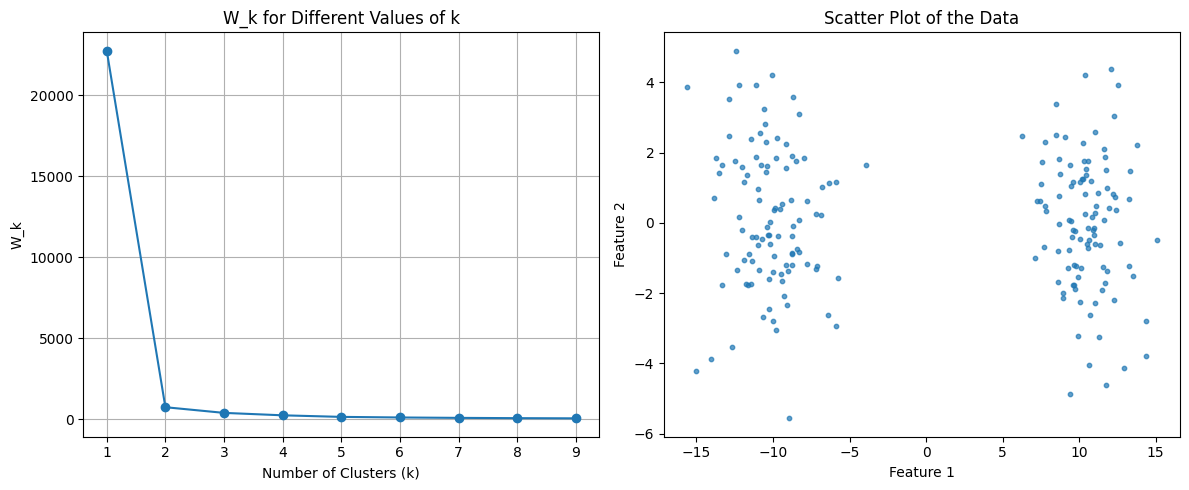

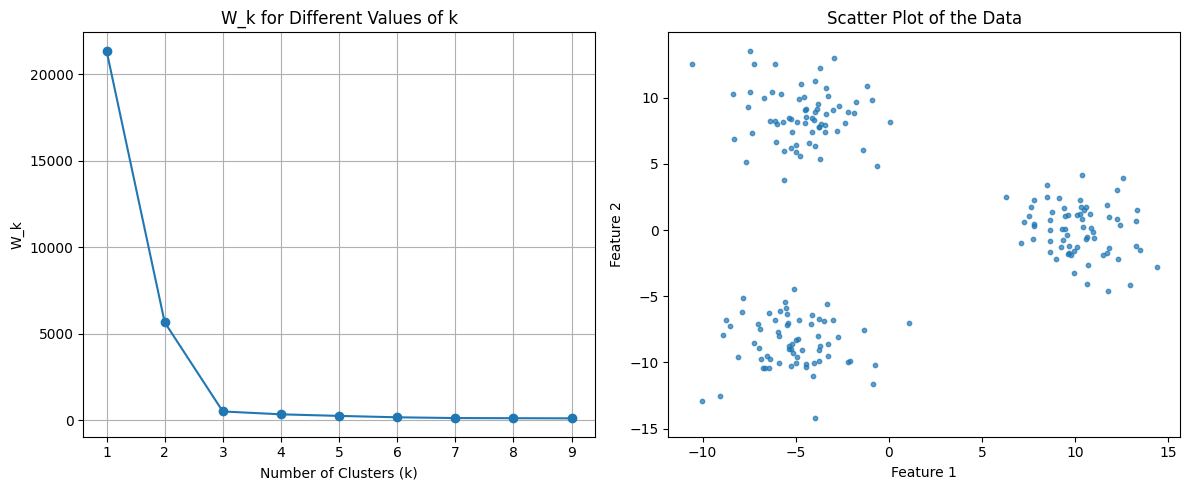

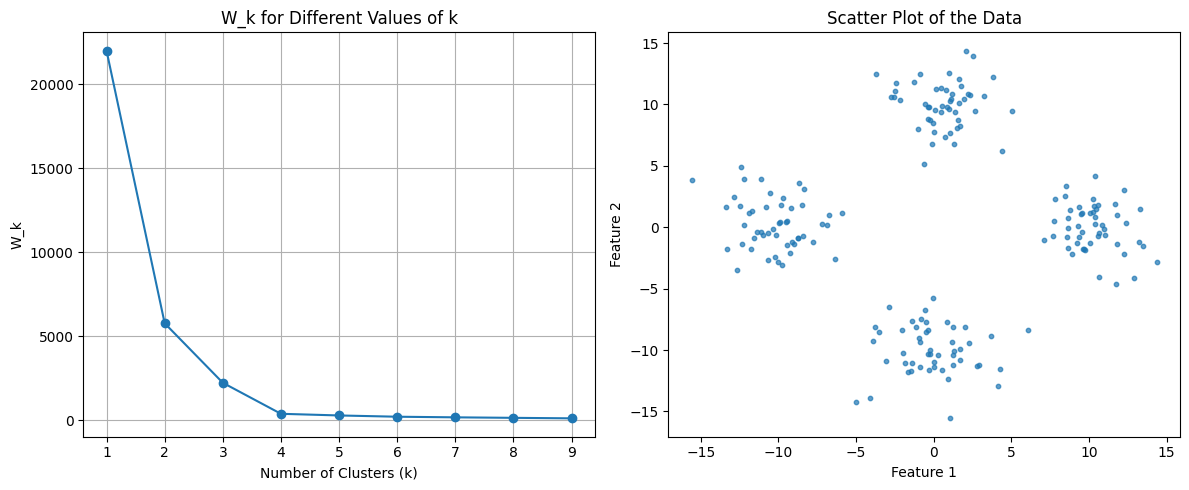

In [ ]:
def plot_wkmean(X, k_range, wkmean_list):
    # Plot the Wk for each k
    _, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot the Wk for each k
    axes[0].plot(k_range, wkmean_list, marker="o")
    axes[0].set_title("W_k for Different Values of k")
    axes[0].set_xlabel("Number of Clusters (k)")
    axes[0].set_ylabel("W_k")
    axes[0].set_xticks(k_range)
    axes[0].grid()

    # Scatter plot of the data
    axes[1].scatter(X[:, 0], X[:, 1], s=10, alpha=0.7)
    axes[1].set_title("Scatter Plot of the Data")
    axes[1].set_xlabel("Feature 1")
    axes[1].set_ylabel("Feature 2")

    plt.tight_layout()
    plt.show()


# let's experiment with different number of clusters
n_true_clusters_range = range(2, 5)
k_range = range(1, 10)  # range of k to test for each experiment

for n_classes in n_true_clusters_range:
    # dataset
    n_samples, n_features = 200, 4
    X, _ = generate_blobs_dataset(n_samples, n_features, n_classes, seed=0)

    wmean_list = []
    for k in k_range:
        # model
        kmeans = KMeansClustering(n_clusters=k)
        kmeans.fit(X)
        # compute Wk mean
        w_k_mean = 1/k * compute_Wk(X, kmeans.labels_, kmeans.centroids)
        wmean_list.append(w_k_mean)

    plot_wkmean(X, k_range, wmean_list)

#### Gap Statistic

**🤔 Key Question**
> *“Is the clustering we observe better than what we would expect if the data had no real structure?”*

Gap Statistic: a principled way to determine the number of clusters $k$ by comparing your clustering results with those you'd expect from **uniformly-distributed random data**.

**STEPS**:
1. Generate $n_{ref}$ synthetic reference dataset:  
    - same **numbers of samples and dimensions** of the original data
    - same **bounds** of the original data
    - but values are sampled from a **uniform distribution** (no inherent clustering)
    - we need $n_{ref}$ reference datasets to average and to not depend too much on the specific realization

2. For each $k$ number of clusters:
    1. Fit a clustering model on your data with $k$ clusters and compute within-cluster dispersions $W(k)$ as defined above.
    2. For each of the synthetic datasets $j \in \{1, 2, ..., n_{ref}\}$:
        - Fit a clustering model on the ref data $j$ with $k$ clusters and compute within-cluster dispersions $W_j^{ref}(k)$.   
    3. Compute the **gap statistic** as:  
        $$
        \text{Gap}(k) = \mathbb{E}_j[\log W_j^{\text{ref}}(k)] - \log W(k)
        $$  
        - A higher gap means your clustering result is **better than random**.
        - It quantifies the gain of using k clusters compared to a structureless dataset.
3. Select the optimal number of clusters.  
    Choose the **smallest** $k$ such that:  
    $$
    \text{Gap}(k) \geq \text{Gap}(k + 1) - s_{k+1}
    $$
    where:
    - $s_{k+1}$ is the **standard deviation** of the **log dispersions** from the reference datasets.
    - This accounts for uncertainty in the random data comparison.


In [ ]:
def generate_reference_dataset(n_samples, n_features, lower_bound, upper_bound):
    """Generate 1 synthetic dataset with uniform distribution."""
    return np.random.uniform(lower_bound, upper_bound, size=(n_samples, n_features))


def optimal_k_with_gap(X, klist, n_ref_datasets=10):
    n_samples, n_features = X.shape
    lower_bounds = [np.min(X[:, i]) for i in range(n_features)]
    upper_bounds = [np.max(X[:, i]) for i in range(n_features)]

    # Step 1: generate reference datasets
    ref_datasets = [generate_reference_dataset(n_samples, n_features, lower_bounds, upper_bounds) for _ in range(n_ref_datasets)]
    gap_list = []
    # Step 2: iterate over k
    for k in klist:
        # Step 2.1 Fit k-means on our data using k clusters
        np.random.seed(4)  # this is a horrible thing to ensure 'proper' centroids... just for the sake of the example!
        kmeans = KMeansClustering(n_clusters=k)
        kmeans.fit(X)
        Wk = compute_Wk(X, kmeans.labels_, kmeans.centroids)

        # Step 2.2 Fit k-means on each reference dataset using k clusters
        Wk_ref = []
        for X_ref in ref_datasets:
            kmeans_ref = KMeansClustering(n_clusters=k)
            kmeans_ref.fit(X_ref)
            Wk_ref.append(compute_Wk(X_ref, kmeans_ref.labels_, kmeans_ref.centroids))

        # compute gap statistic
        log_Wk_rf = np.log(Wk_ref)
        gap = np.mean(np.log(Wk_ref)) - np.log(Wk)
        gap_list.append(gap)
        print(f"Gap statistic for k={k}: {gap}")


    # Step 3: select optimal k
    std_logWk_ref = np.std(log_Wk_rf, axis=0)          # shape (n_ref_datasets, ). Std of each Wk_ref across datasets
    upper_bound = gap_list - std_logWk_ref             # upper bound for the gap statistic

    # take the minimum k for which gap(k) > upper_bound   optimal_k = None
    optimal_k = None
    for i in range(len(gap_list)-1):
        if gap_list[i] >= upper_bound[i+1]:
            optimal_k = klist[i]
            break
    if optimal_k == None:
        optimal_k = klist[-1] # fallback.
        print(f"Warning: optimal k not found. Using k={optimal_k}")

    return optimal_k, gap_list, std_logWk_ref


In [ ]:
np.random.seed(0)
klist = range(1, 7)
optimal_k, gap_list, std_list = optimal_k_with_gap(Xblobs, klist, n_ref_datasets=10)
print(f"Optimal number of clusters: {optimal_k}")

kmeansopt = KMeansClustering(n_clusters=optimal_k).fit(Xblobs)


Gap statistic for k=1: 0.03667207686817697
Gap statistic for k=2: 0.15548591580801485
Gap statistic for k=3: 0.4131113155171544
Gap statistic for k=4: 0.6372654775465492
Gap statistic for k=5: 2.5982831302653704
Gap statistic for k=6: 2.4732845246843738
Optimal number of clusters: 5


C:\Users\zacca\AppData\Local\Temp\ipykernel_9188\3062137201.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


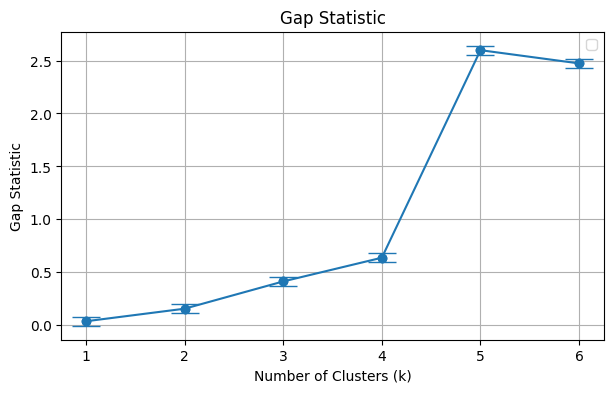

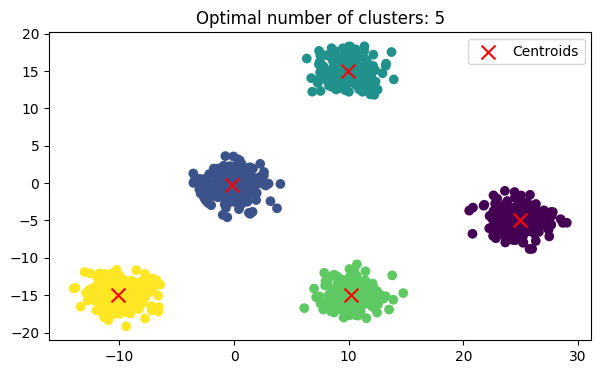

In [ ]:
# plot the gap statistic plot
plt.figure(figsize=(7, 4))
plt.plot(klist, gap_list, marker='o', c='tab:blue')
plt.errorbar(klist, gap_list, yerr=std_list, fmt='o', capsize=10, c='tab:blue')
plt.title('Gap Statistic')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Gap Statistic')
plt.xticks(klist)
plt.legend()
plt.grid()

# plot the clusters
plt.figure(figsize=(7, 4))
plt.scatter(Xblobs[:, 0], Xblobs[:, 1], c=kmeansopt.labels_)
plt.scatter(kmeansopt.centroids[:, 0], kmeansopt.centroids[:, 1], c='red', marker='x', s=100, label='Centroids')
plt.title(f"Optimal number of clusters: {optimal_k}")
plt.legend()
plt.show()

### Agglomerative Hierarchical Clustering (bottom up)

![hc.png](https://cdn.prod.website-files.com/633ec8b202a7496fb9c9dda9/6407a42fca237b08ec8a110e_hierarchical-agglomerative-clustering.png)

1. Each point starts in its own clustering.
2. At each step, we look for the two closest clusters to merge.
3. We stop when 1 or n_clusters are reached

**Distance among clusters**  
There are many ways to define the distance between two clusters. Here we see the **Single Linkage** and **Average Linkage** hierarchical clustering.

For each pair of clusters $C_i, C_j$, we define the min distance as:
$$
d(C_i, C_j) \doteq \min_{a\in C_i,b\in C_j} d(a,b)
$$

and the average distance as:

$$
d(C_i, C_j) \doteq \frac{1}{|C_i||C_j|}\sum_{a\in C_i}\sum_{b\in C_j}d(a,b)
$$

![imag2.png](https://miro.medium.com/v2/resize:fit:1400/1*Vv_0OE7Wwr3_CujLmKyKPA.png)

In [ ]:
def min_cluster_distance(C1, C2):
    """
    Compute the min distance between the two clusters using the Euclidean distance for points

    Args:
        C1: np.ndarray - points in the first cluster, shape (n1, n_features)
        C2: np.ndarray - points in the second cluster, shape (n2, n_features)

    Returns:
        float - the minimum linkage distance between the two clusters
    """
    dist = np.inf
    for i in range(C1.shape[0]):
        for j in range(C2.shape[0]):
            dist = min(dist, np.linalg.norm(C1[i] - C2[j]))
    return dist

def average_cluster_distance(C1, C2):
    """
    Compute the distance between the two clusters using Euclidean distance for points.

    Args:
        C1: np.ndarray - points in the first cluster, shape (n1, n_features)
        C2: np.ndarray - points in the second cluster, shape (n2, n_features)

    Returns:
        float - the average linkage distance between the two clusters
    """
    dist = 0
    for i in range(C1.shape[0]):
        for j in range(C2.shape[0]):
            dist += np.linalg.norm(C1[i] - C2[j])
    dist = dist / (C1.shape[0] * C2.shape[0])
    return dist

#### How to memorize the agglomerative process?
We use a matrix (cluster assignment matrix) <code>cmatrix</code>.

- n rows: each row is an iteration step
- n columns: each column is a sample index

The element `(i,j)` represents the label/cluster assigned to the sample `j` in `X_train` at iteration `i`.

**Example**:

| Step | Sample a | Sample b | Sample c | Sample d | Sample e |                                                  |
|------|----------|----------|----------|----------|----------|--------------------------------------------------------|
| **0**    | 0        | 1        | 2        | 3        | 4        | Initial: each sample in its own cluster                |
| **1**    | 0        | 1        | 2        | 1        | 3        | Samples b and d merged into cluster 1                  |
| **2**    | 0        | 0        | 1        | 0        | 2        | Cluster 0 (sample a) and cluster 1 (samples b-d) are merged into cluster 0             |
| **3**    | 0        | 0        | 1        | 0        | 1        | Clusters 1 and 2 are merged into cluster 1                |
| **4**    | 0        | 0        | 0        | 0        | 0        | Final: all samples in one cluster                      |

⚠️ **Note**: the i-th row of the matrix contains n_samples-i clusters.

In [ ]:
class AgglomerativeHierarchicalClustering:
    """Agglomerative Hierarchical Clustering using Average Linkage and Euclidean distance."""
    def __init__(self, n_clusters, linkage="average", verbose=False):
        assert linkage in ["min", "average"], "Linkage must be 'min' or 'average'."
        self.n_clusters = n_clusters
        self.cmatrix = None
        self.centroids = None
        self.X_train = None
        self.verbose = verbose          # if True, print the cluster assignment matrix and clusters list at each step of build_clusters
        self.linkage = linkage

    def fit(self, X):
        """
        Fit the model to the data and save the cluster assignment matrix.
        Returns the centroids of the clusters.

        Args:
            X: np.ndarray - data to cluster, shape (n_samples, n_features)
            n_clusters: int - number of clusters to use for prediction
            verbose: bool - if True, print the cluster assignment matrix and clusters list at each step of the fit
        """
        self.X_train = X
        self._build_clusters(self.n_clusters)
        self.centroids = self.get_centroids(self.n_clusters)

    def _build_clusters(self, n_clusters):
        """
        Perform the aggregations of clusters until n_clusters clusters are left
        and save the cluster assignment matrix at each step.
        """
        n_samples, n_features = self.X_train.shape

        # to get n_clusters clusters we need to perform n_samples-n_clusters iterations
        n_iters = n_samples - n_clusters

        # initialize cmatrix and clusters list: each sample belongs to its own cluster at the beginning
        self.cmatrix = np.zeros((n_iters + 1, n_samples), dtype=int)        # we want to save also the initial state (+1)
        self.cmatrix[0, :] = np.arange(n_samples)
        clusters = [[i] for i in range(n_samples)]

        if self.verbose:
            print('Iteration 0')
            print('Clusters ', clusters)
            print('Cmatrix ')
            print(self.cmatrix)
            print('\n')

        # iterate until we have n_clusters clusters left (we need n_samples-n_clusters iterations)
        for i in range(1, n_iters + 1):
            # find the two closest clusters
            best_pair = (None, None)
            min_dist = np.inf
            for j in range(len(clusters)):
                for k in range(j+1, len(clusters)):     # we don't need to check the same pair twice
                    Cj = self.X_train[clusters[j]]
                    Ck = self.X_train[clusters[k]]
                    if self.linkage == "min":
                        dist = min_cluster_distance(Cj, Ck)
                    elif self.linkage == "average":
                        dist = average_cluster_distance(Cj, Ck)
                    if dist < min_dist:
                        best_pair = (j, k)
                        min_dist = dist

            # merge the two closest clusters
            j, k = best_pair
            clusters[j] += clusters[k]                  # we are adding the sample indices in cluster k to cluster j
            del clusters[k]                             # and we are removing the cluster/list k

            # update the ith row of cmatrix
            labels = np.zeros(n_samples, dtype=int)     # for each sample we have to assign the new cluster label
            for cluster_idx, clust in enumerate(clusters):
                for sample_idx in clust:
                    labels[sample_idx] = cluster_idx
            self.cmatrix[i, :] = labels

            if self.verbose:
                print('Iteration', i)
                print('Clusters ', clusters)
                print('Cmatrix ')
                print(self.cmatrix)
                print('\n')

    def get_centroids(self, n_clusters):
        """
        Compute the centroids of the clusters using the training set and the cmatrix. The centroid is
        the barycenter of the cluster.

        Notice: cmatrix[i,:] containts the cluster labels for n_samples-i clusters.
        To get the row for n_clusters clusters, we need to take the row n_samples-n_clusters.

        Returns:
            np.ndarray - centroids of the clusters, shape (n_clusters, n_features)
        """
        labels = self.cmatrix[self.X_train.shape[0]-n_clusters, :]
        centroids = np.zeros((n_clusters, self.X_train.shape[1]))
        for i in range(n_clusters):
            # get the samples values in the cluster i
            indices = (labels == i)
            samples = self.X_train[indices]
            # compute the barycenter
            centroids[i,:] = np.mean(samples, axis=0)
        return centroids

    def predict(self, X, n_clusters=None):
        """
        Predict the labels for the samples in X by choosing the closest centroid.
        If n_clusters is not specified, it will use the number of clusters used in fit.
        Otherwise, it will recompute the centroids for the new number of clusters
        from the cmatrix.

        Args:
            X: np.ndarray - data to cluster, shape (n_samples, n_features)
            n_clusters: int - number of clusters to use for prediction (optional)
        """

        if self.cmatrix is None:
            raise RuntimeError("You must fit the model before predicting.")

        if n_clusters is None:
            # use the number of clusters used in fit
            distances = pairwise_distances(X, self.centroids)
        else:
            if n_clusters > self.cmatrix.shape[0]:
                raise ValueError("n_clusters must be less than or equal to the number of clusters used in fit.")
            # recompute the centroids for the new number of clusters
            centroids = self.get_centroids(n_clusters)
            # compute the distances between each sample and each centroid
            distances = pairwise_distances(X, centroids)

        # assign each sample to the nearest centroid
        labels = np.argmin(distances, axis=1)
        return labels.astype(int)

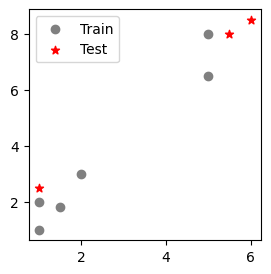

In [ ]:
# example
X_train = np.array([[1.0, 2.0], [5.0, 8.0], [1.0, 1.0],[2.0, 3.0],[1.5, 1.8],[5.0, 6.5],])
X_test = np.array([[1.0, 2.5], [5.5, 8.0], [6.0, 8.5]])
plt.figure(figsize=(3,3))
plt.scatter(X_train[:,0], X_train[:, 1], label="Train", color="gray")
plt.scatter(X_test[:,0], X_test[:, 1], label="Test", color="red", marker="*")
plt.legend()
plt.show()


In [ ]:
# fit and predict with average or min linkage
model = AgglomerativeHierarchicalClustering(n_clusters=2, verbose=True, linkage="average")
model.fit(X_train)

Iteration 0
Clusters  [[0], [1], [2], [3], [4], [5]]
Cmatrix 
[[0 1 2 3 4 5]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


Iteration 1
Clusters  [[0, 4], [1], [2], [3], [5]]
Cmatrix 
[[0 1 2 3 4 5]
 [0 1 2 3 0 4]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


Iteration 2
Clusters  [[0, 4, 2], [1], [3], [5]]
Cmatrix 
[[0 1 2 3 4 5]
 [0 1 2 3 0 4]
 [0 1 0 2 0 3]
 [0 0 0 0 0 0]
 [0 0 0 0 0 0]]


Iteration 3
Clusters  [[0, 4, 2], [1, 5], [3]]
Cmatrix 
[[0 1 2 3 4 5]
 [0 1 2 3 0 4]
 [0 1 0 2 0 3]
 [0 1 0 2 0 1]
 [0 0 0 0 0 0]]


Iteration 4
Clusters  [[0, 4, 2, 3], [1, 5]]
Cmatrix 
[[0 1 2 3 4 5]
 [0 1 2 3 0 4]
 [0 1 0 2 0 3]
 [0 1 0 2 0 1]
 [0 1 0 0 0 1]]




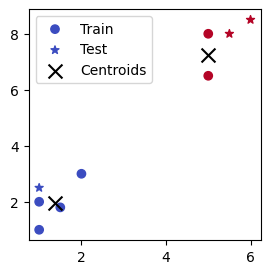

In [ ]:
# we could use predict(X_train) to get the labels, but we don't need to! The **training** labels
# are already in the cmatrix.
y_pred_train = model.cmatrix[-1, :]

# predict labels for new data X_test, instead, requires predict
y_pred_test = model.predict(X_test)

# plot the clusters
plt.figure(figsize=(3,3))
plt.scatter(X_train[:,0], X_train[:, 1], c=y_pred_train, cmap='coolwarm', label="Train")
plt.scatter(X_test[:,0], X_test[:, 1], c=y_pred_test, cmap='coolwarm', label="Test", marker="*")
# plot centroids
plt.scatter(model.centroids[:,0], model.centroids[:, 1], label="Centroids", color="black", marker="x", s=100)
plt.legend()
plt.show()

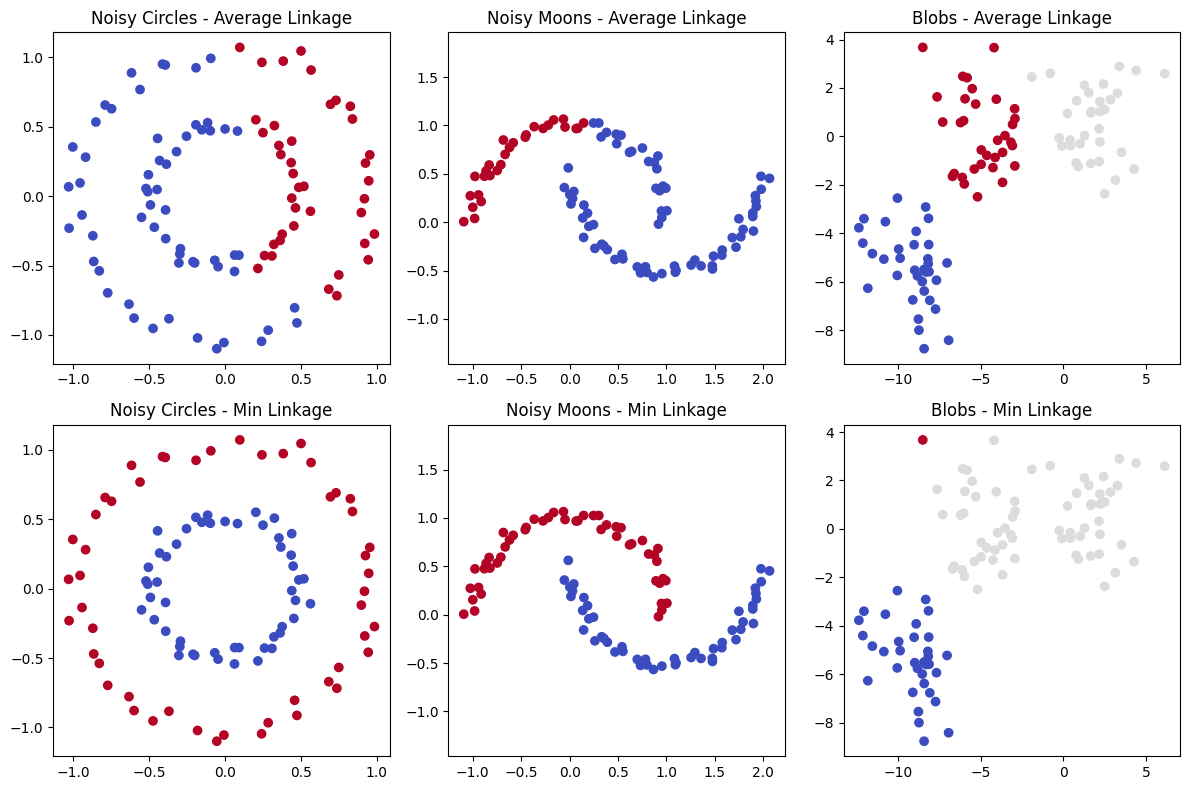

In [ ]:
# Comparing different hierarchical linkage methods on toy datasets
# https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html
from sklearn import datasets

# generate datasets
n_samples = 100
noisy_circles = datasets.make_circles(n_samples=n_samples, noise=0.05, random_state=170, factor=0.5)
X_noisy_circles, y_noisy_circles = noisy_circles

noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05, random_state=170)
X_noisy_moons, y_noisy_moons = noisy_moons

blobs = datasets.make_blobs(n_samples=n_samples, random_state=170, cluster_std=1.5)
X_blobs, y_blobs = blobs

# run the clustering
hc_avg_noisy_circles = AgglomerativeHierarchicalClustering(linkage="average", n_clusters=2)
hc_avg_noisy_circles.fit(X_noisy_circles)
noisy_circles_labels = hc_avg_noisy_circles.cmatrix[-1, :]

hc_min_noisy_circles = AgglomerativeHierarchicalClustering(linkage="min", n_clusters=2)
hc_min_noisy_circles.fit(X_noisy_circles)
noisy_circles_labels_min = hc_min_noisy_circles.cmatrix[-1, :]

hc_avg_noisy_moons = AgglomerativeHierarchicalClustering(linkage="average", n_clusters=2)
hc_avg_noisy_moons.fit(X_noisy_moons)
noisy_moons_labels = hc_avg_noisy_moons.cmatrix[-1, :]

hc_min_noisy_moons = AgglomerativeHierarchicalClustering(linkage="min", n_clusters=2)
hc_min_noisy_moons.fit(X_noisy_moons)
noisy_moons_labels_min = hc_min_noisy_moons.cmatrix[-1, :]

hc_avg_blobs = AgglomerativeHierarchicalClustering(linkage="average", n_clusters=3)
hc_avg_blobs.fit(X_blobs)
blobs_labels = hc_avg_blobs.cmatrix[-1, :]

hc_min_blobs = AgglomerativeHierarchicalClustering(linkage="min", n_clusters=3)
hc_min_blobs.fit(X_blobs)
blobs_labels_min = hc_min_blobs.cmatrix[-1, :]

# plot the results
plt.figure(figsize=(12, 8))
plt.subplot(2, 3, 1)
plt.title("Noisy Circles - Average Linkage")
plt.scatter(X_noisy_circles[:, 0], X_noisy_circles[:, 1], c=noisy_circles_labels, cmap='coolwarm')
plt.subplot(2, 3, 4)
plt.title("Noisy Circles - Min Linkage")
plt.scatter(X_noisy_circles[:, 0], X_noisy_circles[:, 1], c=noisy_circles_labels_min, cmap='coolwarm')
plt.subplot(2, 3, 2)
plt.title("Noisy Moons - Average Linkage")
plt.scatter(X_noisy_moons[:, 0], X_noisy_moons[:, 1], c=noisy_moons_labels, cmap='coolwarm')
plt.axis('equal')
plt.subplot(2, 3, 5)
plt.title("Noisy Moons - Min Linkage")
plt.scatter(X_noisy_moons[:, 0], X_noisy_moons[:, 1], c=noisy_moons_labels_min, cmap='coolwarm')
plt.axis('equal')
plt.subplot(2, 3, 3)
plt.title("Blobs - Average Linkage")
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=blobs_labels, cmap='coolwarm')
plt.subplot(2, 3, 6)
plt.title("Blobs - Min Linkage")
plt.scatter(X_blobs[:, 0], X_blobs[:, 1], c=blobs_labels_min, cmap='coolwarm')
plt.tight_layout()
plt.show()


Let's plot intermediate results

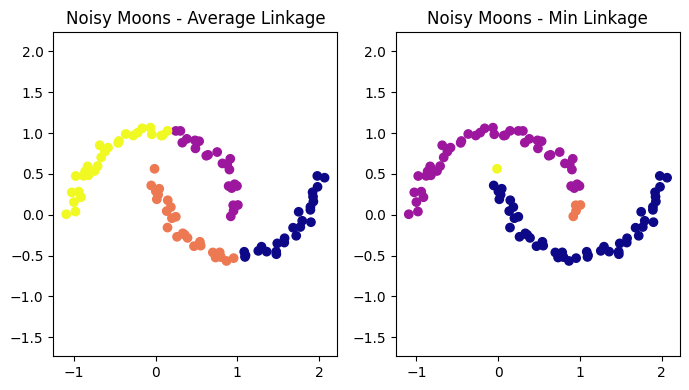

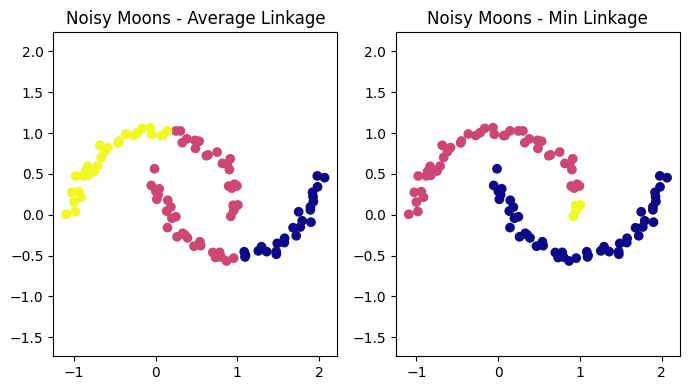

In [ ]:
inter_cluster_min = hc_min_noisy_moons.cmatrix[96, :]
inter_cluster_avg = hc_avg_noisy_moons.cmatrix[96, :]

# plot
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.title("Noisy Moons - Average Linkage")
plt.scatter(X_noisy_moons[:, 0], X_noisy_moons[:, 1], c=inter_cluster_avg, cmap='plasma')
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.title("Noisy Moons - Min Linkage")
plt.scatter(X_noisy_moons[:, 0], X_noisy_moons[:, 1], c=inter_cluster_min, cmap='plasma')
plt.tight_layout()
plt.axis('equal')
plt.show()

inter_cluster_min = hc_min_noisy_moons.cmatrix[97, :]
inter_cluster_avg = hc_avg_noisy_moons.cmatrix[97, :]

# plot
plt.figure(figsize=(7, 4))
plt.subplot(1, 2, 1)
plt.title("Noisy Moons - Average Linkage")
plt.scatter(X_noisy_moons[:, 0], X_noisy_moons[:, 1], c=inter_cluster_avg, cmap='plasma')
plt.axis('equal')
plt.subplot(1, 2, 2)
plt.title("Noisy Moons - Min Linkage")
plt.scatter(X_noisy_moons[:, 0], X_noisy_moons[:, 1], c=inter_cluster_min, cmap='plasma')
plt.tight_layout()
plt.axis('equal')
plt.show()


**Average Linkage on Iris**

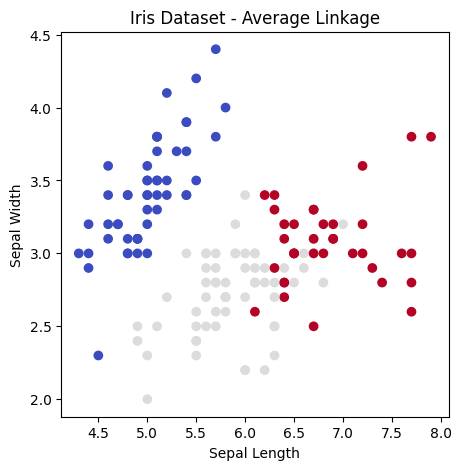

In [ ]:
data = pd.read_csv("drive/MyDrive/AA24-25ML/iris.csv")
Xiris = data.iloc[:, :-1].to_numpy()
yiris = data.iloc[:, -1].to_numpy()

hciris = AgglomerativeHierarchicalClustering(linkage="average", n_clusters=3)
hciris.fit(Xiris)
iris_labels = hciris.cmatrix[-1, :]

plt.figure(figsize=(5, 5))
plt.title("Iris Dataset - Average Linkage")
plt.scatter(Xiris[:, 0], Xiris[:, 1], c=iris_labels, cmap='coolwarm')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.show()

## Anomaly Detection

### Hotelling $T^2$ Test


For multivariate outlier detection.

**What is an outlier?**  
A sample that is very different from the rest of the data.

**A simple way to check if a point is far from our "normal" data**  
1. Compute the mean of the train data
2. Calculate the square error of that point with respect to the mean
3. To account for the scale of the data, we can divide the square error by the variance of the data

#### Univariate case
Let's first consider the univariate case: we have data points along a single feature, or dimension.

The "distance" of a point $x$ from the mean $\mu$ is given by:
$$
\frac{(x - \mu)^2}{\sigma^2}
$$
where $\sigma^2$ is the variance of the data.

This is basically what we will do with Hotelling's $T^2$.


Distance of outlier from mean: [24.02525823]


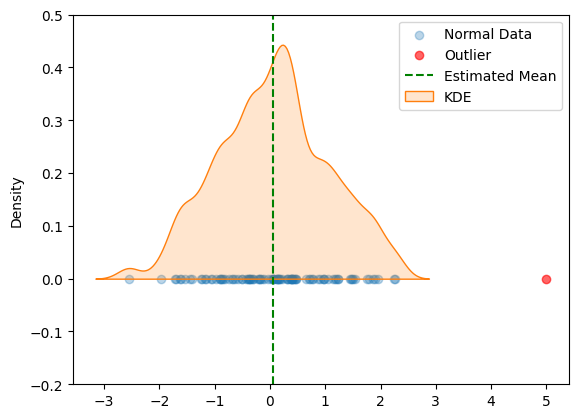

In [ ]:
np.random.seed(0)
X = np.random.normal(size=(100))

mean = np.mean(X)
var = np.var(X)

outlier = np.array([5])

distance = (outlier - mean)**2 / var
print(f"Distance of outlier from mean: {distance}")

# scatter plot
plt.scatter(X, [0]*len(X), alpha=0.3, label='Normal Data')
plt.scatter(outlier, [0], color='red', alpha=0.6, label='Outlier')
plt.axvline(x=mean, color='green', linestyle='--', label='Estimated Mean')
sns.kdeplot(X, bw_adjust=0.5, fill=True, alpha=0.2, label='KDE')
plt.ylim(-0.2, 0.5)
plt.legend()

#### Multivariate case

In the multivariate case, we have $p$ features, and we can represent our data as a $n \times p$ matrix $X$.

We can compute the mean of the data as:
$$
\mu = \frac{1}{n} \sum_{i=1}^n x_i
$$
where $x_i$ is the $i$-th row of the data matrix $X$.  
We also compute the covariance matrix of the data as:
$$
S = cov(X)
$$
Hotelling's $T^2$ statistic is given by:
$$
T^2 = (x - \mu)^T S^{-1} (x - \mu)
$$
where $x$ is the point we want to test.

> Ok, now we have a sort of distance measure, how do we decide if a point is an outlier or not?

We can use a $\chi^2$ distribution to determine the threshold for the $T^2$ statistic.
The $T^2$ statistic follows a $\chi^2$ distribution with $p$ degrees of freedom.

We can compute the critical value, also called UCL (Upper Control Limit) as:
$$
UCL = \chi^2_{p, 1 - \alpha}
$$
where $p$ is the number of features and $\alpha$ is the significance level.  
The critical value is the value above which we consider a point to be an outlier.

**What does that mean?**  
Basically we are saying that we want a (for examle) 95% confidence that the point we are testing is not an outlier.
In that case we have $\alpha = 0.05$

**In simple terms, what are we doing?**
As for all things, we like to simplify problems.
> *In physics one may say: "Let's assume that this cow can be approximated as a sphere".*
In data science, the equivalent is: "Let's assume that the data is normally distributed".

Text(0.5, 1.0, 'Very serious dataset')

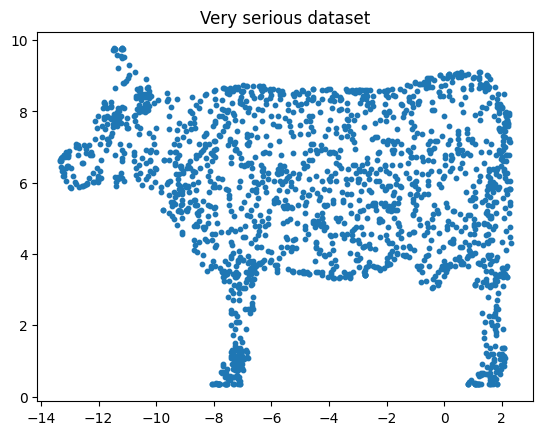

In [ ]:
df = pd.read_csv('drive/MyDrive/AA24-25ML/cow.csv')
X = df.to_numpy()

plt.scatter(X[:, 0], X[:, 1], s=10)
plt.title('Very serious dataset')

With Hotelling's $T^2$ test we are assuming that the data is normally distributed, we compute mean and covariance of the train dataset, and check if a new point is too far from the mean, with a confidence level we chose (like 95% or 99%).

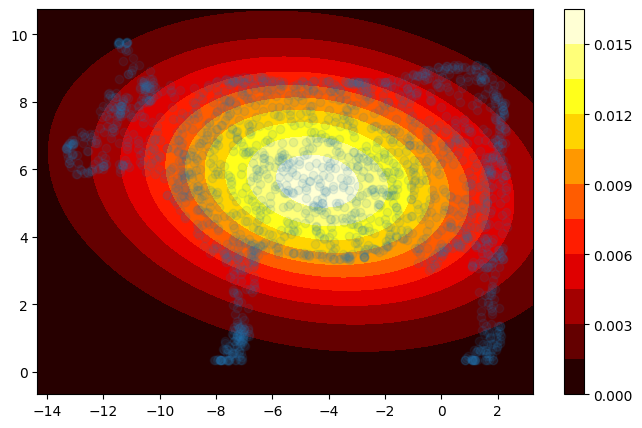

In [ ]:
from scipy.stats import multivariate_normal

# basically, we are approximating the cow with a Gaussian:
mean = np.mean(X, axis=0)
cov = np.cov(X, rowvar=False)

# plot
x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
x, y = np.mgrid[x_min:x_max:0.1, y_min:y_max:0.1]
pos = np.dstack((x, y))
rv = multivariate_normal(mean, cov)
plt.figure(figsize=(8, 5))
contour = plt.contourf(x, y, rv.pdf(pos), levels=10, cmap="hot")
plt.colorbar(contour)
plt.scatter(X[:, 0], X[:, 1], alpha=0.1, color="C0")

From the contour plot of the gaussian distribution, you can see that we have various confidence ellipsoids we could chose to use, in order to detect outliers.

In [ ]:
from scipy.stats import chi2


class HotellingT2:
    def __init__(self, alpha) -> None:
        """Initialize the mean and (inverse) covariance matrix."""
        self.mean = 0.0
        self.inv_cov = 0.0
        self.alpha = alpha

    def fit(self, X_train):
        """Fit multivariate Gaussian distribution to the data."""
        self.mean = np.mean(X_train, axis=0)  # save the mean
        self.cov = np.cov(X_train, rowvar=False)
        self.inv_cov = np.linalg.inv(self.cov)  # save the inverse covariance matrix

    def compute_T_squared(self, X):
        """Hotelling's T² statistic: T² = (x - mean)ᵀ Σ⁻¹ (x - mean)"""
        t2_scores = []
        for x in X:  # for each sample in X
            t2 = (x - self.mean).T @ self.inv_cov @ (x - self.mean)
            t2_scores.append(t2)
        return np.array(t2_scores)

    @staticmethod
    def chi_squared_threshold(p, alpha):
        """Chi-squared threshold for multivariate normality."""
        return chi2.ppf(1 - alpha, df=p)

    def predict(self, X):
        """Predict outliers based on Hotelling's T² scores and chi-squared threshold."""
        # Compute the threshold for the chi-squared distribution
        n_features = X.shape[1]
        threshold = self.chi_squared_threshold(n_features, self.alpha)
        t2_scores = self.compute_T_squared(X)  # Compute T² scores
        return t2_scores > threshold  # Identify outliers based on the threshold

Text(0.5, 1.0, "Hotelling's T² decision boundary 95% confidence")

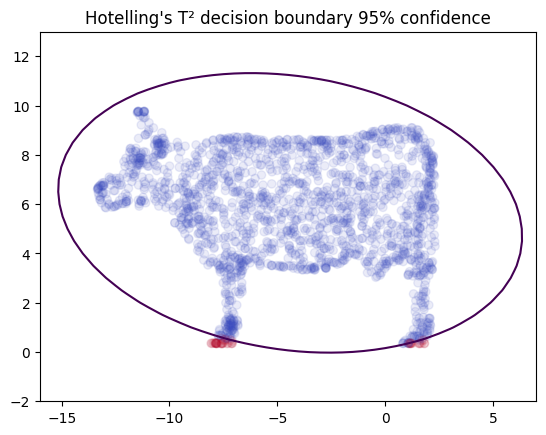

In [ ]:
# Outlier prediction on the original data

alpha = 0.05 # choose a significance level

# Create an instance of the HotellingT2 class
hotelling_model = HotellingT2(alpha=alpha)

# Fit the model to the training data
hotelling_model.fit(X)

# Predict outliers in the train data
y_pred = hotelling_model.predict(X)

# Plot the T^2 scores as a contour plot
x_min, x_max, y_min, y_max = -16, 7, -2, 13
x, y = np.mgrid[x_min:x_max:0.5, y_min:y_max:0.5]
grid_points = np.column_stack((x.flatten(), y.flatten()))
t2_grid_scores = hotelling_model.compute_T_squared(grid_points)
threshold = hotelling_model.chi_squared_threshold(X.shape[1], alpha)
contour = plt.contour(x, y, t2_grid_scores.reshape(x.shape), levels=[threshold])
plt.scatter(X[:, 0], X[:, 1], alpha=0.1, c=y_pred.astype(int), cmap="coolwarm")
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.title(f"Hotelling's T² decision boundary {1-alpha:.0%} confidence")

### Isolation Forest

<span style="color:red"><strong>🏋️‍♀️ Exercise</strong></span>

Implement an Isolation Tree using the same structure of Decision Tree and complete the class Isolation Forest. Assume that there are **no** categorical features.

We use the same class structure as in decision trees (Lab5). However, we don't need <code>_find_best_split</code> nor <code>_find_best_threshold</code> because each split
is now random. Moreover, the prediction function changes - we don't have target labels, we use the **corrected** depth.

Corrected depth: if we stop growing the tree because of max depth, then the depth of the node must be corrected as `depth(node) = depth(node) + c(n_samples_in_node)`.

In [ ]:
def c(n):
    """
    Average depth of a tree with n_samples samples or equivalently
    average path length of an unsuccessful search in a BST.
    """
    if n <= 1:
        return 0
    elif n == 2:
        return 1
    else:
        return 2 * (np.log(n-1) + np.euler_gamma - (n-1)/n)

In [ ]:
@dataclass
class Node:
    feature: int | None         # Feature index for split, None for leaf
    threshold: float | None     # Threshold for split, None for leaf
    depth: int                  # Depth of the node in the tree

In [ ]:
class IsolationTree:
    def __init__(self, max_depth):
        self.max_depth = max_depth

    @staticmethod
    def _split_dataset(X, feature, threshold):
        left_mask = X[:, feature] <= threshold
        right_mask = X[:, feature] > threshold
        return left_mask, right_mask

    @staticmethod
    def _child_id(node_id, is_left):
        if is_left:
            return 2 * node_id + 1
        else:
            return 2 * node_id + 2

    def _random_split(self, X):
        """ Randomly select a feature and threshold for splitting. """
        f = np.random.randint(0, X.shape[1])
        threshold = np.random.uniform(X[:, f].min(), X[:, f].max())
        return f, threshold


    def _build_tree(self, X, depth, node_id):
        """Construct the tree recursively."""
        n_samples_node = X.shape[0]

        # -- LEAF CONDITIONS --
        # 0. All feature values of all samples are the same (no split possible)
        # 1. The node has 0 or 1 samples (no split possible)
        # 2. Max depth is reached

        X_all_same = all(len(np.unique(X[:, f])) == 1 for f in range(X.shape[1]))

        if n_samples_node <= 1 or depth >= self.max_depth or X_all_same:
            # we need to correct the depth of the leaf node if we stop because of maxdepth and with more than 1 samples
            depth = depth + c(n_samples_node)           # if only 1 sample, c returns 0 -> no correction
            self.nodes[node_id] = Node(None, None, depth)
            return

        # -- Internal Node: split randomly and create children --
        feature, threshold = self._random_split(X)
        self.nodes[node_id] = Node(feature, threshold, depth)

        left_mask, right_mask = self._split_dataset(X, feature, threshold)
        left_id = self._child_id(node_id, True)
        right_id = self._child_id(node_id, False)

        self._build_tree(X[left_mask], depth + 1, left_id)
        self._build_tree(X[right_mask], depth + 1, right_id)

    def fit(self, X):
        """
        Fit the isolation tree to the data.

        Args:
            X: np.ndarray of shape (n_subsamples, n_features), the data to fit the tree to.
        """
        self.nodes = dict()
        self._build_tree(X, 0, 0)

    def get_depth(self, X):
        """
        Return the depth reached by each sample in X in the tree.
        """
        depths = []
        for x in X:
            node_id = 0
            node : Node = self.nodes[0]
            while True:
                if node.feature is None: # leaf node
                    depths.append(node.depth)
                    break
                # else we need to go down the tree
                is_left = x[node.feature] <= node.threshold
                node_id = self._child_id(node_id, is_left)
                node = self.nodes[node_id]
        return np.array(depths)

In [ ]:
class IsolationForest:
    def __init__(self,
                 contamination:int=0.1,
                 n_estimators:int=100,
                 max_samples:int=256,
                 max_depth:int=8):
        """
        Args:
            contamination: float - the proportion of outliers in the data.
            n_estimators: int - the number of trees in the forest.
            max_samples: int - the maximum number of samples in each tree.
            max_depth: int - the maximum depth of each tree.
        """
        # set hyperparameters
        self.contamination = contamination
        self.n_estimators = n_estimators
        self.max_samples = max_samples
        self.max_depth = max_depth

        # initialize attributes
        self.threshold = None
        self.trees = []

    def fit(self, X):
        """Fit the forest to the dataset
        For each tree:
        1. Subsample the data (with or without replacement)
        2. (subsample the features)
        3. Fit the tree to the subsampled data
        """
        self.max_samples = min(self.max_samples, X.shape[0])

        for t in range(self.n_estimators):
            # randomly subsample the data
            sampled_indices = np.random.choice(X.shape[0], self.max_samples, replace=False)
            X_subsample = X[sampled_indices, :]

            # fit tree
            tree = IsolationTree(self.max_depth)
            tree.fit(X_subsample)
            self.trees.append(tree)

        # define the threshold from the contamination parameter.
        # It is important to make this step here, as the threshold is defined considering
        # the anomaly scores of the training set (not any other set).
        training_scores = self.decision_function(X)
        self._set_threshold(training_scores)
        return self


    def _set_threshold(self, training_scores):
        """
        See the anomaly score threshold based on contamination.
        """
        self.threshold = np.percentile(training_scores, 100 * (1 - self.contamination))


    def decision_function(self, X):
        """
        Compute anomaly scores for each sample x in X as: a(x)=2**(-E_t[h_t(x)]/c(n_t)) where:
            E_t[h_t(x)] is the average depth of the sample x in the trees t in the forest
            c(n_t) is the normalization factor, average depth of a tree fitted with n_t samples.
        """
        # get the depth of each sample in each tree
        depths = np.zeros((X.shape[0], self.n_estimators))
        for i, tree in enumerate(self.trees):
            depths[:, i] = tree.get_depth(X)

        # compute the average depth for each sample
        avg_depths = np.mean(depths, axis=1)

        # compute the average depth of a tree with n_samples nodes
        c_n = c(self.max_samples)

        # compute the anomaly score
        scores = 2 ** (-avg_depths / c_n)

        return scores

    def predict(self, X):
        """
        Return 0 if the point is predicted as normal, 1 if it is predicted as an anomaly.
        It is based on the anomaly score and the contamination parameter.
        """
        if self.threshold is None:
            raise ValueError("The model has not been fitted yet. Please call fit() before predict().")

        scores = self.decision_function(X)
        return (scores > self.threshold).astype(int)


#### Isolation Forest on California Housing

In [ ]:
data = pd.read_csv('drive/MyDrive/AA24-25ML/california_housing.csv')
X = data[["MedInc", "AveRooms"]].to_numpy()
print(X.shape)


(20640, 2)


In [ ]:
# train model and get scores
iforest = IsolationForest()
iforest.fit(X)
scores = iforest.decision_function(X)

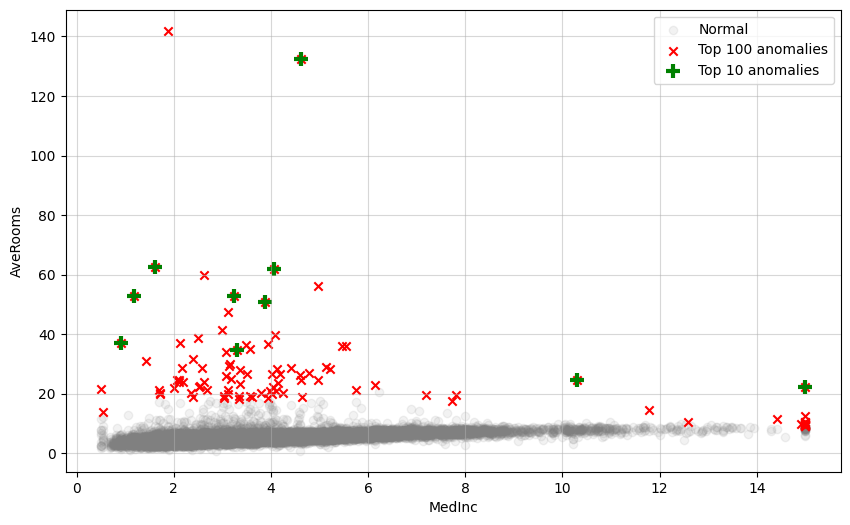

In [ ]:
# take the top 10, 100 anomalies
sorted_indices = np.argsort(scores)[::-1]
top_10_idx = sorted_indices[:10]
top_100_idx = sorted_indices[:100]
normal_indices = sorted_indices[100:]

plt.figure(figsize=(10,6))
plt.scatter(X[normal_indices,0], X[normal_indices, 1], label="Normal", color="gray", alpha=0.1)
plt.scatter(X[top_100_idx,0], X[top_100_idx, 1], label="Top 100 anomalies", color="red", marker="x")
plt.scatter(X[top_10_idx,0], X[top_10_idx, 1], label="Top 10 anomalies", color="green", marker="+", s=90, linewidths=3 )
plt.legend()
plt.xlabel("MedInc")
plt.ylabel("AveRooms")
plt.grid(alpha=0.5)
plt.show()

#### Evaluate Unsupervised Anomaly Detection
One way is **synthetic injection**: we add known anomalies to the dataset (e.g. noise, out-of-distributions) points and we check if our model finds them.

In [ ]:
# compute the mean and the standard deviation of the features
means = np.mean(X, axis=0)
stds = np.std(X, axis=0)

# add samples with values that deviate from the mean of the features (anomalies)
divergent_rows = np.array([
    [means[0] + 7 * stds[0], means[1] + 3 * stds[1]],
    [means[0] + 3 * stds[0], means[1] + 10 * stds[1]],
    [means[0] + 6 * stds[0], means[1] + 5 * stds[1]],
    [means[0] + 4 * stds[0], means[1] + 12 * stds[1]],
    [means[0] + 3 * stds[0], means[1] + 8 * stds[1]],
    [means[0] + 4 * stds[0], means[1] + 3 * stds[1]],
])
X_augmented = np.vstack([X, divergent_rows])

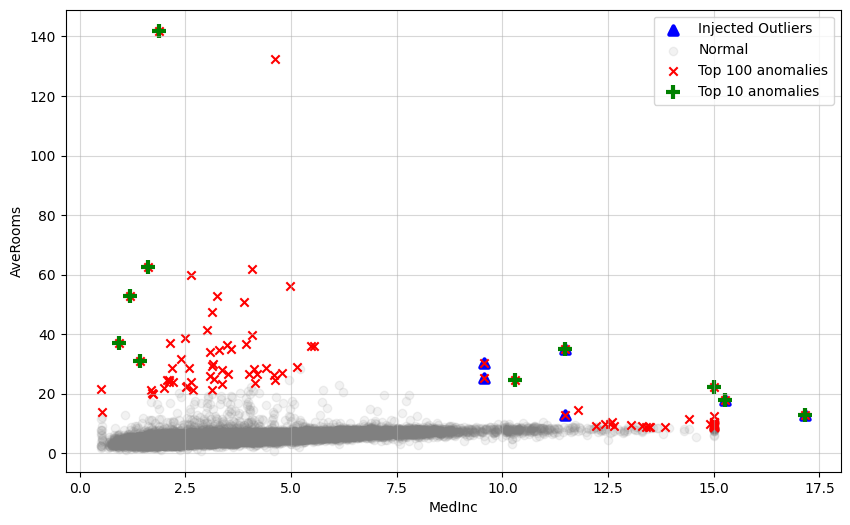

In [ ]:
# Train model
iforest2 = IsolationForest()
iforest2.fit(X_augmented)
scores2 = iforest2.decision_function(X_augmented)

# Anomaly ranking
sorted_indices = np.argsort(scores2)[::-1]
top_10_idx = sorted_indices[:10]
top_100_idx = sorted_indices[:100]
normal_indices = sorted_indices[100:]

# Injected point indices
new_points_idx = np.arange(X.shape[0], X_augmented.shape[0])

# Plot results
plt.figure(figsize=(10,6))
plt.scatter(X_augmented[new_points_idx, 0], X_augmented[new_points_idx, 1],label="Injected Outliers", color="blue", marker="^", linewidths=3)
plt.scatter(X_augmented[normal_indices,0], X_augmented[normal_indices, 1], label="Normal", color="gray", alpha=0.1)
plt.scatter(X_augmented[top_100_idx,0], X_augmented[top_100_idx, 1], label="Top 100 anomalies", color="red", marker="x")
plt.scatter(X_augmented[top_10_idx,0], X_augmented[top_10_idx, 1], label="Top 10 anomalies", color="green", marker="+", s=90, linewidths=3 )
plt.legend()
plt.xlabel("MedInc")
plt.ylabel("AveRooms")
plt.grid(alpha=0.5)
plt.show()

#### (Optional) Isoation forest bias

Bias may mean different things in different contexts. In this case we mean that in some cases, the IF may represent an anomaly score that is not consistent with the actual data.

Let's see a synthetic example to illustrate this. We will generate a dataset with 2D Gaussian clusters and then we will apply the Isolation Forest algorithm to it.

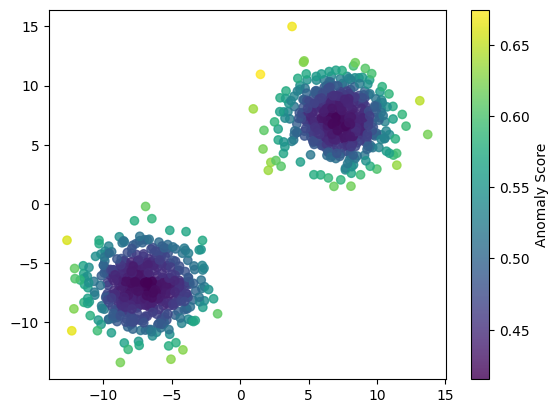

In [ ]:
from utils import generate_blobs_dataset
X, y = generate_blobs_dataset(n_samples=1000, n_features=2, n_classes=2, seed=0, phi=np.pi/4)

iforest = IsolationForest()
iforest.fit(X)
scores = iforest.decision_function(X)

scatter = plt.scatter(X[:, 0], X[:, 1], c=scores, alpha=0.8)
plt.colorbar(scatter, label='Anomaly Score')

The result is pretty good. But let's evaluate the anomaly score of many points in the space. We will generate a grid of points and evaluate the anomaly score of each point. Then we will plot the results.

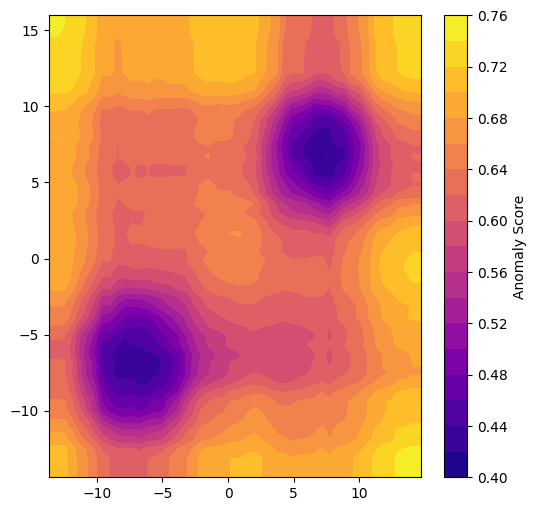

In [ ]:
from utils import create_2d_meshpoints

X_grid, xx, yy, X_2d = create_2d_meshpoints(X, resolution=50)
n_features = X.shape[1]

predict_proba = lambda x: iforest.decision_function(x)[..., np.newaxis]

# contourf of the decision function on the grid points
plt.figure(figsize=(6, 6))
plt.contourf(xx, yy, predict_proba(X_grid).reshape(xx.shape), levels=20, cmap="plasma")
plt.colorbar(label='Anomaly Score')

As we can see, darker colors represent "normal" data points, and in fact we see two dark spots where the clusters are.

But there are also darker areas in the space, relatively far from the clusters, in these areas we may have anomalous points that our model is not able to detect.